In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri Jul  9 04:46:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

To enable a high-RAM runtime, select the Runtime > "Change runtime type"
menu, and then select High-RAM in the Runtime shape dropdown. Then, 
re-execute this cell.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten

# data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Checking the Dataset

py = 0, ey = 1

In [12]:
with h5py.File("/content/drive/My Drive/Projects/GSoC 2021/electron-photon-dataset/photon.hdf5", "r") as f:
  px = np.asarray(f['X'][()], dtype=np.float32)
  py = np.asarray(f['y'][()], dtype=np.float32)
  print("Loaded photon dataset!")

with h5py.File("/content/drive/My Drive/Projects/GSoC 2021/electron-photon-dataset/electron.hdf5", "r") as f:
  ex = np.asarray(f['X'][()], dtype=np.float32)
  ey = np.asarray(f['y'][()], dtype=np.float32)
  print("Loaded electron dataset!")

print("Photon dataset shape:", px.shape, py.shape)
print("Electron dataset shape:", ex.shape, ey.shape)

Loaded photon dataset!
Loaded electron dataset!
Photon dataset shape: (249000, 32, 32, 2) (249000,)
Electron dataset shape: (249000, 32, 32, 2) (249000,)


In [13]:
max_photon, min_photon = np.max(px[:, :, :, 0]), np.min(px[:, :, :, 0])
max_electron, min_electron = np.max(ex[:, :, :, 0]), np.min(ex[:, :, :, 0])

print(max_photon, min_photon)
print(max_electron, min_electron)
max(max_photon, abs(min_photon), max_electron, abs(min_electron))

1.4849443 0.0
1.431813 0.0


1.4849443

In [14]:
#sample_size = 10000

X = np.concatenate((px[:, :, :, 0], ex[:, :, :, 0]), axis=0)
y = np.concatenate((py[:], ey[:]), axis=0)

#_, X, _, y = train_test_split(X, y, test_size=sample_size, random_state=88)

print(X.shape, y.shape)

(498000, 32, 32) (498000,)


In [15]:
print("Proton:", np.argmax(np.mean(px[:, :, :, 0], axis=0)))
print("Electron:", np.argmax(np.mean(ex[:, :, :, 0], axis=0)))

Proton: 528
Electron: 528


In [16]:
center = [int(528/32), 528%32]

img_size = 8

X = X[:, (center[0]-int(img_size/2)):(center[0]+int(img_size/2)), (center[1]-int(img_size/2)):(center[1]+int(img_size/2))]
X.shape

(498000, 8, 8)

Train set shape: (423300, 8, 8) (423300, 2)
Test set shape: (74700, 8, 8) (74700, 2)


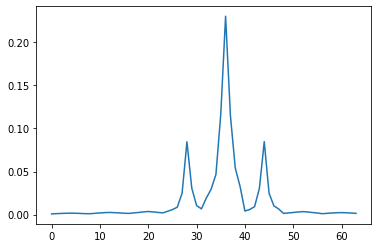

In [17]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=2021)

scaler = StandardScaler()
scaler.fit(x_train.reshape(-1, img_size*img_size))
x_train = scaler.transform(x_train.reshape(-1, img_size*img_size))
x_train = x_train.reshape(-1, img_size, img_size)
y_train = tf.keras.utils.to_categorical(y_train)

x_test = scaler.transform(x_test.reshape(-1, img_size*img_size))
x_test = x_test.reshape(-1, img_size, img_size)
y_test = tf.keras.utils.to_categorical(y_test)

print("Train set shape:", x_train.shape, y_train.shape)
print("Test set shape:", x_test.shape, y_test.shape)

plt.plot(scaler.scale_)

In [18]:
# final reshape to flatten the image

x_train = x_train.reshape([-1,64])
x_test = x_test.reshape([-1,64])

print("Train set shape:", x_train.shape, y_train.shape)
print("Test set shape:", x_test.shape, y_test.shape)

Train set shape: (423300, 64) (423300, 2)
Test set shape: (74700, 64) (74700, 2)


# Model Training

In [19]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [20]:
# Training parameters
BATCH_SIZE = 128  # orig paper trained all networks with batch_size=128
EPOCHS = 200 # 200

# Print parameters for sanity check
print("Batch size, epochs:", BATCH_SIZE, EPOCHS)

Batch size, epochs: 128 200


# Classical Fully-connected NN

In [35]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(3, activation='relu', input_shape=(64,)))
model.add(tf.keras.layers.Dense(2, activation='softmax'))

In [36]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 3)                 195       
_________________________________________________________________
dense_19 (Dense)             (None, 2)                 8         
Total params: 203
Trainable params: 203
Non-trainable params: 0
_________________________________________________________________


In [37]:
opt_adam = tf.keras.optimizers.Adam(learning_rate=lr_schedule(0))

model.compile(loss='categorical_crossentropy',
              optimizer=opt_adam,
              metrics=['accuracy', tf.keras.metrics.AUC()])

Learning rate:  0.001


In [38]:
import time
#start_time = time.time()

last_epoch = 0

H = model.fit(x_train, y_train, initial_epoch=last_epoch,
              batch_size=BATCH_SIZE,
              epochs=10,
              validation_data=(x_test, y_test),
              shuffle=True,
              #callbacks=callbacks
              )

print(H.history)

Epoch 1/10
3308/3308 [==============================] - 12s 3ms/step - loss: 0.6675 - accuracy: 0.6047 - auc: 0.6414 - val_loss: 0.6479 - val_accuracy: 0.6242 - val_auc: 0.6697
Epoch 2/10
3308/3308 [==============================] - 10s 3ms/step - loss: 0.6444 - accuracy: 0.6277 - auc: 0.6756 - val_loss: 0.6420 - val_accuracy: 0.6307 - val_auc: 0.6798
Epoch 3/10
3308/3308 [==============================] - 10s 3ms/step - loss: 0.6412 - accuracy: 0.6319 - auc: 0.6809 - val_loss: 0.6398 - val_accuracy: 0.6337 - val_auc: 0.6833
Epoch 4/10
3308/3308 [==============================] - 10s 3ms/step - loss: 0.6398 - accuracy: 0.6328 - auc: 0.6834 - val_loss: 0.6387 - val_accuracy: 0.6344 - val_auc: 0.6852
Epoch 5/10
3308/3308 [==============================] - 10s 3ms/step - loss: 0.6388 - accuracy: 0.6350 - auc: 0.6849 - val_loss: 0.6380 - val_accuracy: 0.6361 - val_auc: 0.6864
Epoch 6/10
3308/3308 [==============================] - 10s 3ms/step - loss: 0.6381 - accuracy: 0.6360 - auc: 0.686

In [39]:
max(H.history['val_auc'])

0.6913571953773499